# Adoption of the Replying Tool (Beta Features)

[Task](https://phabricator.wikimedia.org/T249386)

June 2020

# Background

In [T244872](https://phabricator.wikimedia.org/T244872) and [T245794](https://phabricator.wikimedia.org/T245794) the reply tool was released as an opt-in beta feature for the following partner wikis: Arabic, Dutch, French and Hungarian. Version 1.0 of the replying tool was deployed on to the partner wikis on March 31, 2020 and Version 2.0 was deployed.

We would like to know how the tool is being used and adopted by the partner wikis as a Beta Feature prior to deploying the  tool to all volunteers as an opt-out preference on the four partner wikis [T249394](https://phabricator.wikimedia.org/T249394).

# Data

Data for this analysis comes from the [PrepUpdate](https://meta.wikimedia.org/wiki/Schema:PrefUpdate) table, the [user properties](https://www.mediawiki.org/wiki/Manual:User_properties_table/en) table, and [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history) table. 

For metrics that were calculated using mediawiki_history, we reviewed data from the release of Version 1.0 on March 31 through the end of May 2020 (the most recent data available at the time of this analysis).


In [382]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(glue); library(lubridate); library(scales)
})

# 1. From 31-March-2020 onward, how many people have used the Reply tool? 

    - How many people have made 1 edit w/ DiscussionTools?
    - How many people have made 2-5 edits w/ DiscussionTools?
    - How many people have made 5-10 edits w/ DiscussionTools?
    - How many people have made 10+ edits w/ DiscussionTools?

Notes: 
- Data comes from mediawiki_history using the new change tag implemented in [T242184](https://phabricator.wikimedia.org/T242184). 
- We reviewed all edits made with discussiontools tag. These include all users who were able to successfully make an edit using the reply tool. It does not include attempts with the tool that were not saved. 
- Any identified bots were filtered out from the data.

In [ ]:
# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G
query <- "
-- obtain reply edits
with edits AS (
SELECT
    wiki,
    reply_user,
    CASE
        WHEN max(reply_edits) is NULL THEN 'undefined'
        WHEN max(reply_edits) = 1 THEN '1 edit'
        WHEN max(reply_edits) BETWEEN 2 AND 5 THEN '2-5 edits'
        WHEN max(reply_edits) BETWEEN 5 and 10 THEN '5-10 edits'
        ELSE '10+'
        END AS reply_edit_count
FROM (
    SELECT
        wiki_db AS wiki,
        event_user_id as reply_user,
        max(size(event_user_is_bot_by) > 0 or size(event_user_is_bot_by_historical) > 0) as bot_by_group,
        Count(*) as reply_edits
FROM wmf.mediawiki_history
WHERE 
    ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
    snapshot = '2020-05' AND
    event_timestamp >= '2020-03-31' AND 
    event_timestamp <= '2020-05-31' AND
    wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
    event_entity = 'revision' AND
    event_type = 'create'
GROUP BY
    wiki_db,
    event_user_id  
) edits
WHERE not bot_by_group
GROUP BY reply_user, wiki
)

-- Main Query -- 
SELECT 
    wiki,
    reply_edit_count,
    COUNT(*) as n_users
FROM edits
GROUP BY wiki, reply_edit_count"

results <- collect(sql(query))
save(results, file="Data/reply_edit_users.RData")

In [174]:
load("Data/reply_edit_users.RData")
reply_edit_users <- results

In [175]:
reply_edit_users$reply_edit_count <- factor(reply_edit_users$reply_edit_count,levels = 
                                            c("1 edit", "2-5 edits", "5-10 edits", "10+"))

## Number of users that made reply edits by edit count group

In [371]:
reply_edit_totals_bygroup <- reply_edit_users %>%
    group_by(reply_edit_count) %>%
    summarise(n_users = sum(n_users)) %>%
    mutate(percent_reply_users = n_users/sum(n_users)*100)

reply_edit_totals_bygroup

reply_edit_count,n_users,percent_reply_users
<fct>,<dbl>,<dbl>
1 edit,73,28.294574
2-5 edits,91,35.271318
5-10 edits,14,5.426357
10+,80,31.007752


Since deployment of the reply tool to the end of May, the majority of reply tool users (71.2%) have made more than 1 edit using the tool with most (35.3%) making between 2 to 5 edits. In addition, most users either made between 2 to 5 or over 10 edits, indicating that if a user makes more than 5 edits they are likely to make at least 10 or more reply edits. 

## Number of users that made reply edits by partner wiki

In [198]:
reply_edit_users_bywiki <- reply_edit_users %>%
    spread(reply_edit_count, n_users)

reply_edit_users_bywiki

wiki,1 edit,2-5 edits,5-10 edits,10+
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
arwiki,20,15,2,21
frwiki,37,51,8,30
huwiki,7,11,NA,15
nlwiki,9,14,4,14


In [356]:
reply_edit_users_bywiki_prop <- reply_edit_users %>%
    group_by(wiki) %>%
    mutate(pct_users = n_users/sum(n_users))

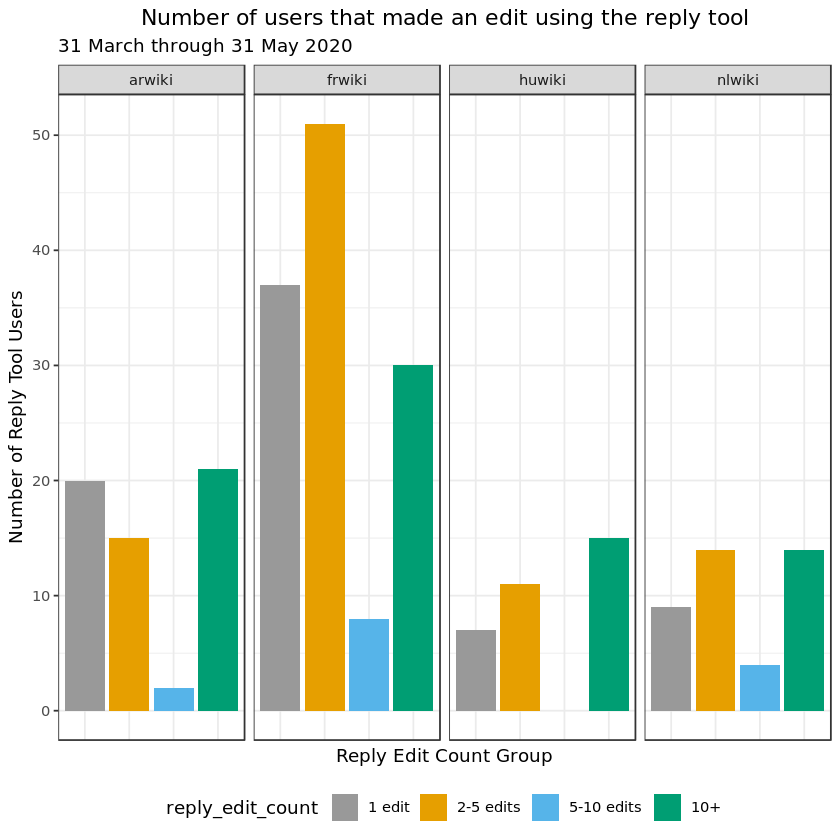

In [389]:
# by wiki

cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73")

p <- reply_edit_users %>%
    ggplot(aes(x=reply_edit_count, y = n_users, fill = reply_edit_count)) +
    geom_bar(stat = 'identity') +
    facet_grid(~wiki) +
    labs (y = "Number of Reply Tool Users",
          x = "Reply Edit Count Group",
         title = "Number of users that made an edit using the reply tool",
         subtitle = "31 March through 31 May 2020")  +
     theme_bw() +
    scale_fill_manual(values=cbPalette) +
   theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.position = "bottom",
        plot.title = element_text(hjust = 0.5)) 
 
        
p

In [233]:
ggsave("Figures/reply_edit_users_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

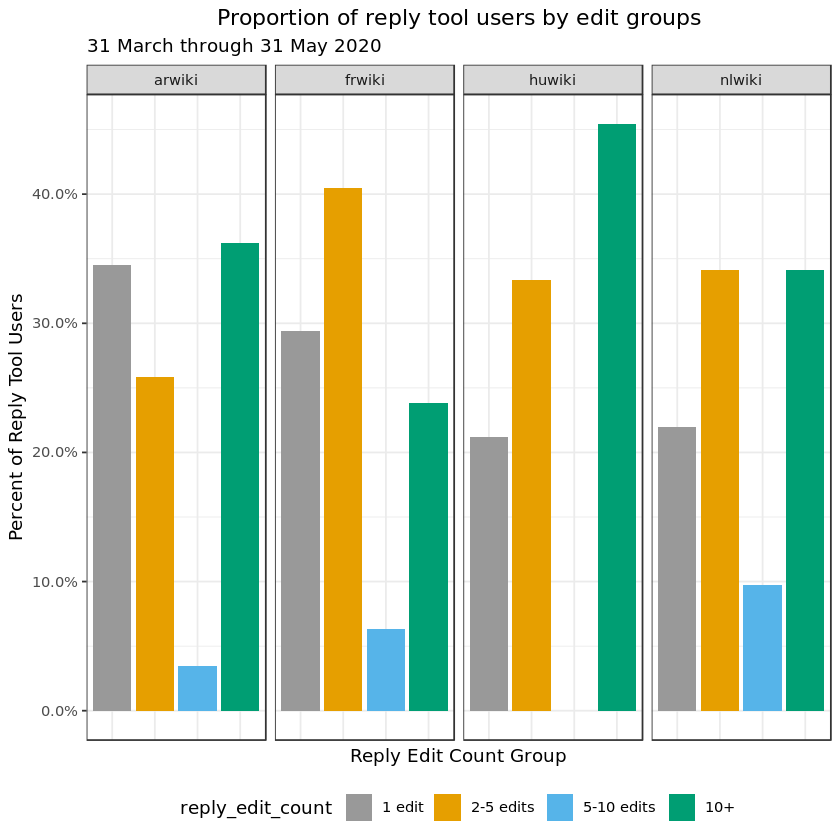

In [372]:
p <- reply_edit_users_bywiki_prop %>%
    ggplot(aes(x=reply_edit_count, y = pct_users, fill = reply_edit_count)) +
    geom_bar(stat = 'identity') +
    facet_grid(~wiki) +
    labs (y = "Percent of Reply Tool Users",
          x = "Reply Edit Count Group",
         title = "Proportion of reply tool users by edit groups",
         subtitle = "31 March through 31 May 2020")  +
    scale_y_continuous(labels = percent) +
    theme_bw() +
    scale_fill_manual(values=cbPalette) +
    theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.position = "bottom",
        plot.title = element_text(hjust = 0.5)) 
 
        
p

In [373]:
ggsave("Figures/reply_edit_users_bywiki_prop.png", p, width = 16, height = 8, units = "in", dpi = 300)

Similar trends are seen on a per wiki basis. The '5-10' edit count group represents the smallest edit group on all four partner wikis.  On Arabic Wikipedia, there were more users that made either 1 edit or over 10 edits then 2-5 or 5-10 edits, indicating users there are largely split between highly active reply tools users and those that tested the tool just once within the timeframe.

On French Wikipedia, the majority of reply tool users (around 40%) made between 2-5 edits using the tool; while on Hungarian Wikipedia the majority of reply tool users (around 45%) made at least 10 edits using the reply tool.

# 2. How often are people using the Reply tool to make talk page edits?

    - How many people have made ≥1 edit w/ DiscussionTools on 1 day?
    - How many people have made ≥1 edit w/ DiscussionTools on 2-5 different days?
    - How many people have made ≥1 edit w/ DiscussionTools on 5-10 different days?
    - How many people have made ≥1 edit w/ DiscussionTools on 10+ days different days ?


Notes: 
- Similar to the calculations above, we reviewed data comes from mediawiki_history. We reviewed all edits made with the discussiontools change tag. 
- A distinct day was defined as a distinct calendar day; therefore, some of these edits may have occurred 24 hours apart and some may have occured only a few hours apart depending on what time of day the edit was made; however, it provides a useful estimation of repeat usage of the tool or "stickiness of the tool". 

In [ ]:
# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G
query <- "
-- obtain reply edits
with days AS (
SELECT
    wiki,
    reply_user,
     CASE
        WHEN COUNT(DISTINCT(day_of_activity))  is NULL THEN 'undefined'
        WHEN COUNT(DISTINCT(day_of_activity))  = 1 THEN '1 day'
        WHEN COUNT(DISTINCT(day_of_activity))  BETWEEN 2 AND 5 THEN '2-5 days'
        WHEN COUNT(DISTINCT(day_of_activity))  BETWEEN 5 and 10 THEN '5-10 days'
        ELSE '10+ days'
        END AS days_of_activity
FROM (
    SELECT
        wiki_db AS wiki,
        event_user_id as reply_user,
        to_date(event_timestamp) as day_of_activity
    FROM wmf.mediawiki_history
    WHERE 
        ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
        snapshot = '2020-05' AND
        event_timestamp >= '2020-03-31' AND 
        event_timestamp <= '2020-05-31' AND
        wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND 
        event_entity = 'revision' AND
        event_type = 'create'
) edits
GROUP BY reply_user, wiki
)

-- Main Query -- 
SELECT 
    wiki,
    days_of_activity,
    COUNT(*) as n_users
FROM days
GROUP BY wiki, days_of_activity"

results <- collect(sql(query))
save(results, file="Data/reply_days_activity.RData")

In [186]:
load("Data/reply_days_activity.RData")
reply_days_activity <- results

In [189]:
reply_days_activity$days_of_activity <- factor(reply_days_activity$days_of_activity,levels = 
                                            c("1 day", "2-5 days", "5-10 days", "10+ days"))

## Reply users distinct days of activity overall

In [390]:
reply_days_activity_bygroup <- reply_days_activity %>%
    group_by(days_of_activity) %>%
    summarise(n_users = sum(n_users)) %>%
    mutate(percent_reply_users = n_users/sum(n_users)*100)

reply_days_activity_bygroup

days_of_activity,n_users,percent_reply_users
<fct>,<dbl>,<dbl>
1 day,101,39.147287
2-5 days,79,30.620155
5-10 days,21,8.139535
10+ days,57,22.093023


## Reply user distinct days of activity by partner wiki

In [199]:
reply_days_activity_bywiki <- reply_days_activity %>%
    spread(days_of_activity, n_users)

reply_days_activity_bywiki

wiki,1 day,2-5 days,5-10 days,10+ days
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
arwiki,26,12,5,15
frwiki,52,45,8,21
huwiki,10,8,3,12
nlwiki,13,14,5,9


In [271]:
reply_days_activity_bywiki_prop <- reply_days_activity %>%
    group_by(wiki) %>%
    mutate(pct_users = n_users/sum(n_users))


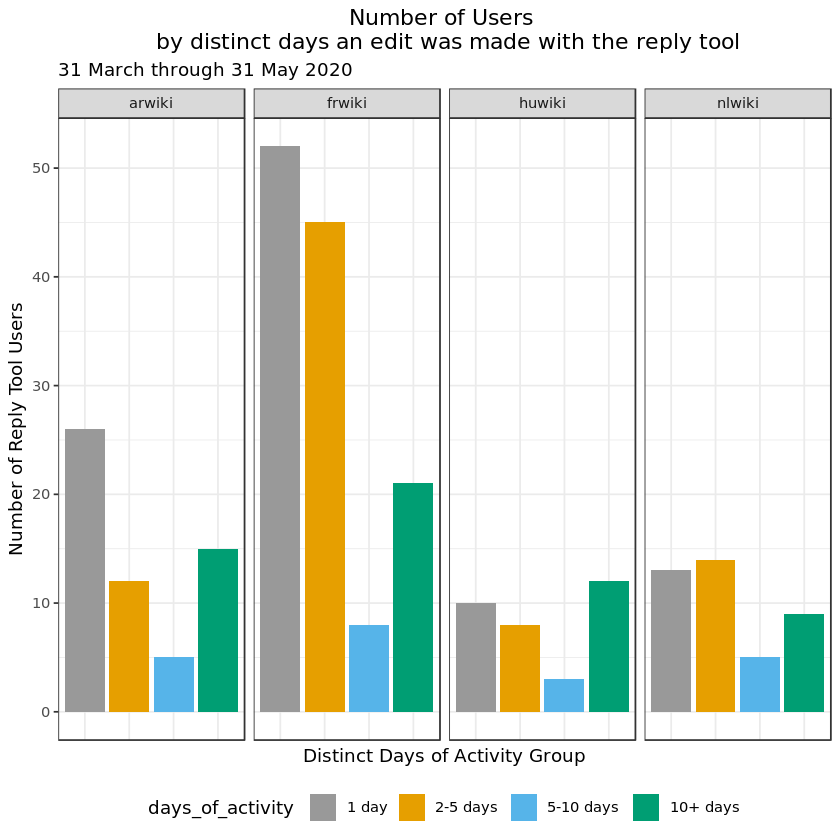

In [393]:
# numbers of days by wiki

cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73")

p <- reply_days_activity %>%
    ggplot(aes(x=days_of_activity, y = n_users, fill = days_of_activity)) +
    geom_col() +
    facet_grid(~wiki) +
    labs (y = "Number of Reply Tool Users",
          x = "Distinct Days of Activity Group",
         title = "Number of Users \n by distinct days an edit was made with the reply tool",
         subtitle = "31 March through 31 May 2020")  +
     theme_bw() +
    scale_fill_manual(values=cbPalette) +
   theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.position = "bottom",
        plot.title = element_text(hjust = 0.5)) 
 
        
p

In [394]:
ggsave("Figures/reply_days_activity_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

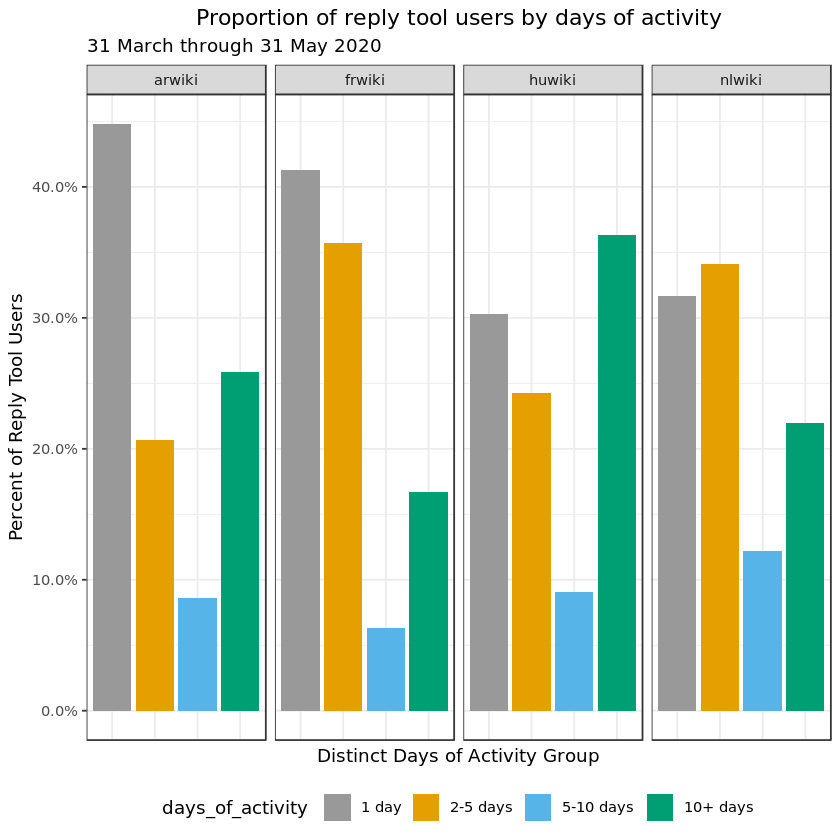

In [395]:
# proportion of distinct days

p <- reply_days_activity_bywiki_prop %>%
    ggplot(aes(x=days_of_activity, y = pct_users, fill = days_of_activity)) +
    geom_col() +
    facet_grid(~wiki) +
    labs (y = "Percent of Reply Tool Users",
          x = "Distinct Days of Activity Group",
         title = "Proportion of reply tool users by days of activity",
         subtitle = "31 March through 31 May 2020")  +
    scale_y_continuous(labels = percent) +
     theme_bw() +
    scale_fill_manual(values=cbPalette) +
   theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.position = "bottom",
        plot.title = element_text(hjust = 0.5)) 
 
        
p

In [396]:
ggsave("Figures/reply_days_activity_bywiki_prop.png", p, width = 16, height = 8, units = "in", dpi = 300)

On French and Dutch Wikipedia, most reply tool users made there edits in 1 to 5 distinct days; while on Hungarian and Arabic Wikipedia, the two largest users groups were those that made their edits on either 1 day or on 10+ distinct days. Both Arabic and Hungarain also had a large proportion of users that made over 10 edits indicating a large number of highly active, repeat reply tool users on those wikis. 

# 3. From 31-March-2020 onward, how many people have had access to the Reply tool ? 

    - How many people have explicitly turned on the Discussion Tools Beta Feature?
    - How many people had the DiscussionTools Beta Feature turned on for them? 
    - How many people have turned off the DiscussionTools Beta Feature? 

##  How many people have explicitly turned on or turned off the Beta Feature? 


Notes: 
- Data comes from the PrefUpdate table. We reviewed data available at the time of this analysis from 31 March until June 26th. 
- "Explicitly" indicates users did not have the Automatically enable all new beta features preference checked.
- For this analysis, I counted whenever a user turned on the beta feature (event.value =1). Thus, if a user at some point decided to turn it off and on again, we'd count them again in the data.
- There are several data QA issues with the PrefUpdate that may impact the results. 
   - There was a drop in pref-update data starting on 2020-05-11 through 2020-06-05. https://phabricator.wikimedia.org/T253151. This is annotated on the figures below.  
    - Analysis assumes that event.value =0 indicates that the beta feature was disabled; however, the isdefualt field is recording false for both event.value = 1 and event.value = 0 properites and disable rate seems off from what is expected. Further investigation is needed.
    - The schema contains multiple identical events for the same preference update https://phabricator.wikimedia.org/T218835. I identified over 100 duplicate events for the discussiontool-betaenable prooerty. 


In [316]:
# Find all users that turned on the beta feature or turned the feature off

# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G

query <- "

with dt_optins AS (
SELECT
    event.userid as userid,
    CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
    wiki, 
    event.value as beta_selection
FROM event.prefupdate 
WHERE 
    event.property = 'discussiontools-betaenable' AND
    wiki IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) >= '2020-03-31' AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) <= '2020-06-26'
)
-- main query to obtain aggregated data
SELECT
    date,
    wiki,
    beta_selection,
    Count(*) n_opt
FROM dt_optins
GROUP BY
    date,
    userid,
    wiki,
    beta_selection
"

In [317]:
reply_beta_optins <- wmf::query_hive(query)

In [318]:
reply_beta_optins$date <- as.Date(reply_beta_optins$date, format = "%Y-%m-%d")

In [320]:
reply_beta_optins$beta_selection <- ifelse(reply_beta_optins$beta_selection == '\"1\"', "opt_in", "opt_out")

## Total Number of Users that Explicilty turned on or turned off the Beta Feature

In [321]:
#Note. We are missing data at end of july so the numbers are likely lower than reported here.
n_optins_total <- reply_beta_optins %>%
    group_by(beta_selection)%>%
    summarise(n_opt_total = sum(n_opt))
    
n_optins_total

beta_selection,n_opt_total
<chr>,<int>
opt_in,2367
opt_out,4426


We recorded a total of 2,367 users that turned on the beta feature since deployed on March 31 through June 26, 2019. We unfortunately missing data from 05 May 2020 through 2020 June 05 so this is likely an underestimate of the total number of users that enabled the feature.
Note:  The data for opt-outs seem high and inconsistent with expected trends. Need to confirm assumption that event.value = 0 indicates the tool was disabled.


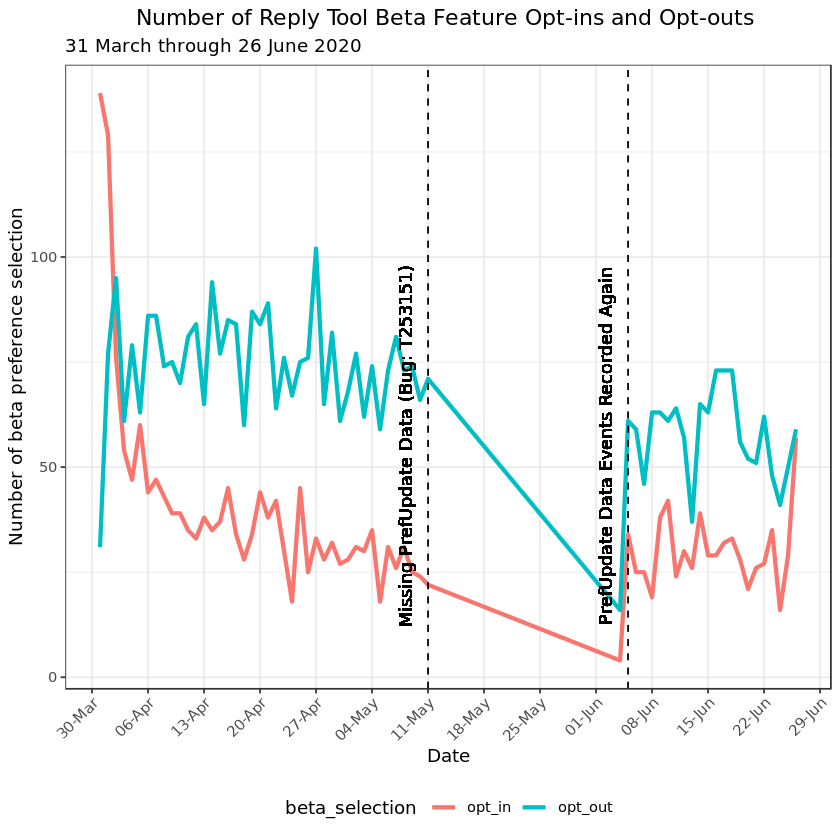

In [401]:
# Chart opt in and opt out rate over time
# Note: There was a drop in pref-update data starting on 2020-05-11 through 2020-06-05	
# https://phabricator.wikimedia.org/T253151
p <- reply_beta_optins %>%
    group_by(date, beta_selection)  %>%
    summarise(n_opt = sum(n_opt)) %>%
    ggplot(aes(x= date, y = n_opt, color = beta_selection)) +
    geom_line(size = 1.2) +
    geom_vline(xintercept = as.Date(c('2020-05-11', '2020-06-05')),
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2020-05-11'), y=55, label="Missing PrefUpdate Data (Bug: T253151)"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2020-06-05'), y=55, label="PrefUpdate Data Events Recorded Again"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Number of beta preference selection",
          x = "Date",
         title = "Number of Reply Tool Beta Feature Opt-ins and Opt-outs ",
         subtitle = "31 March through 26 June 2020")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 
 
        
p


In [402]:
ggsave("Figures/reply_optin_rate.png", p, width = 16, height = 8, units = "in", dpi = 300)

## Number of Users that explicilty turned on or turned off the Beta Feature By Wiki

In [388]:
# review opt-ins by wiki
n_optins_bywiki <- reply_beta_optins %>%
    filter(beta_selection == 'opt_in') %>%
    group_by(wiki)%>% 
    summarise(n_opt_in = sum(n_opt)) 


n_optins_bywiki

wiki,n_opt_in
<chr>,<int>
arwiki,707
frwiki,1280
huwiki,150
nlwiki,230


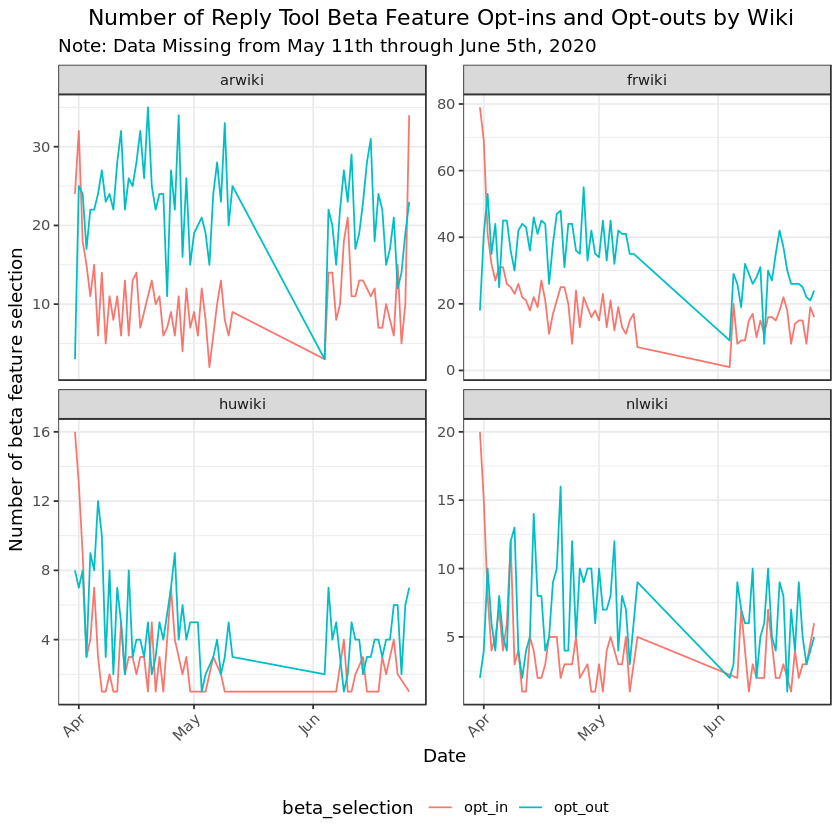

In [403]:
# Chart opt in rate by wiki

p <- reply_beta_optins %>%
    group_by(date, wiki, beta_selection)  %>%
    summarise(n_opt = sum(n_opt)) %>%
    ggplot(aes(x= date, y = n_opt, color = beta_selection)) +
    geom_line() +
    facet_wrap(~wiki, scales = "free_y") +
    scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
    labs (y = "Number of beta feature selection",
          x = "Date",
         title = "Number of Reply Tool Beta Feature Opt-ins and Opt-outs by Wiki ",
         subtitle = "Note: Data Missing from May 11th through June 5th, 2020")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 
 

           
p

In [404]:
ggsave("Figures/reply_optin_rate_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

It looks like there are several duplicate events in PrefUpdate. I checked the number of duplicates to confirm the impact. There are 100 events that have been copies for discussiontools-betaenable. I updated the open phab task [T218835](https://phabricator.wikimedia.org/T218835) to document the identified bug. 

In [334]:
query <-"SELECT event.property AS property, COUNT(*) AS duplicated_events
FROM (
  SELECT event, COUNT(*) AS copies
  FROM event.prefupdate 
  WHERE 
    event.property = 'discussiontools-betaenable' AND
    wiki IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) >= '2020-03-31' AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) <= '2020-06-26'
  GROUP BY event
  HAVING copies > 1) AS events
GROUP BY event.property
ORDER BY property LIMIT 10000;"

In [335]:
reply_beta_duplicate_events <- wmf::query_hive(query)

In [336]:
head(reply_beta_duplicate_events)

,property,duplicated_events
,<chr>,<int>
1,discussiontools-betaenable,100


This is a relatively large number of duplicates but it appears that most of the duplicate values but shouldn't signficantly impact the overall trends indicated by the data which indicate that the the opt-in and opt-out rate for the discussion tool has stablized after an initial overall decrease. 

## How many people had the DiscussionTools Beta Feature turned on for them?


 Notes: 
 - "Turned on for them": Indicates users had the following preference checked: Automatically enable all new beta features.
 - Data comes from the mediawiki [user properties](https://www.mediawiki.org/wiki/Manual:User_properties_table/en) table, where property is equal to 'betafeatures-auto-enroll'.
 - Data represents total numbers of users that have set this preference as of June 29th, 2020. 
 - Analysis in separate python notebook (auto_beta_users_collect.ipynb)

|        | Number of Auto Enrolled Beta Users | 
|--------|--------------|
| arwiki | 9927         | 
| nlwiki | 1274         | 
| frwiki | 8170         | 
| huwiki | 558          | 

# 4. How many people should we expect to try the Replying feature when it is turned on as an opt-out user preference for all users, at our four partner wikis?

 Notes:
 - Data from mediawiki_history.
 - We reviewed the latest 30 days available at the time of analysis: 1-31 March 2020.

In [147]:
## Upper bound: number of people who have made at least 1 edit, 
## in any namespace, in the previous 30 day period
query <- "
    SELECT
    wiki,
    count(*) AS n_editors
FROM (
    SELECT
        event_user_id as user_id,
        wiki_db AS wiki,
        max(size(event_user_is_bot_by) > 0 or size(event_user_is_bot_by_historical) > 0) as bot_by_group,
        COUNT(*) as edits
    FROM wmf.mediawiki_history
    WHERE
        event_timestamp >= '2020-05-01' AND 
        event_timestamp <= '2020-05-31' AND
        event_entity = 'revision' AND
        event_type = 'create' AND
        wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
        snapshot = '2020-05' AND
        event_user_id != 0
    GROUP BY 
        event_user_id,
        wiki_db
) edits
WHERE
    not bot_by_group 
GROUP BY 
    wiki"

In [148]:
upper_bound_editors <- wmf::query_hive(query)

In [151]:
## Lower bound: number of people who have made at least 1 edit 
##in a talk namespace in the previous 30 day period
query <- "
    SELECT
    wiki,
    count(*) AS n_editors
FROM (
    SELECT
        event_user_id as user_id,
        wiki_db AS wiki,
        max(size(event_user_is_bot_by) > 0 or size(event_user_is_bot_by_historical) > 0) as bot_by_group,
        COUNT(*) as edits
    FROM wmf.mediawiki_history
    WHERE
        event_timestamp >= '2020-05-01' AND 
        event_timestamp <= '2020-05-31' AND
        event_entity = 'revision' AND
        event_type = 'create' AND
        page_namespace_historical % 2 == 1 AND
        wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
        snapshot = '2020-05' AND
        event_user_id != 0
    GROUP BY 
        event_user_id,
        wiki_db
) edits
WHERE
    not bot_by_group 
GROUP BY 
    wiki"

In [152]:
lower_bound_editors <- wmf::query_hive(query)

## Expected Users Per Wiki: Upper and Lower Bounds (Based on numbers from 1-31 March 2020)

|        | upper bound | lower bound |
|--------|-------------|-------------|
| arwiki | 7,996       | 1,896       |
| nlwiki | 4,804       | 758         |
| frwiki | 22,727      | 3,945       |
| huwiki | 2,201       | 445         |

# 5. From 31-March-2020 onward, how often are people using the Reply tool to make talk page edits?

Of the people who have made at least one edit with the Reply tool, how many of these people have made >5%, >10%, >25% and >50% - of their total talk page edits during the identified time period using the tool?

Notes:
- Data comes from mediawiki_history. 
- Reply tool edits: Any edit marked by discussiontool change tag. 
- Talk Page edits: Any edit made in any of the talk pages.
- This metric has some slight noise as there could be cases where the following people end up looking the same in the data. In this case, both Person A and Person B would end up in the >50% bucket: Person A: made a total two edits to talk pages, one of which was with the Reply tool; Person B: made a total of 150 talk page edits, 75 of which were with the Reply tool.
- There are a couple cases where there are reply edits were recorded but no talk page edits marked for the user. I removed these for this analysis but further investigation is needed. 

In [ ]:
# Obtain reply edits and total talk edits 
# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G

#see if inner join makes difference
query <- "
-- obtain all users who have made at least 1 edit with the reply tool

with reply_users AS(
SELECT
    event_user_id AS reply_user,
    wiki_db AS reply_wiki
FROM wmf.mediawiki_history
WHERE 
    ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
    snapshot = '2020-05' AND
    event_timestamp >= '2020-03-31' AND 
    event_timestamp <= '2020-05-31' AND
    wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND NOT
    ARRAY_CONTAINS(event_user_groups_historical, 'bot') AND
    event_entity = 'revision' AND 
    event_type = 'create' 
)
-- obtain user talk and reply counts
SELECT
    user,
    wiki,
    SUM(CAST(reply_edit as int)) as reply_edits,
    SUM(CAST(talk_edit as int)) as talk_edits
FROM (
    SELECT
        event_user_id as user,
        wiki_db AS wiki,
        array_contains(revision_tags, 'discussiontools') as reply_edit,
        page_namespace_historical % 2 == 1 as talk_edit
    FROM
        wmf.mediawiki_history
    WHERE
        event_timestamp >= '2020-03-31' AND 
        event_timestamp <= '2020-05-31' AND
        event_entity = 'revision' AND
        event_type = 'create' AND
        wiki_db IN ('arwiki','nlwiki', 'frwiki', 'huwiki') AND
        snapshot = '2020-05' AND NOT
        ARRAY_CONTAINS(event_user_groups_historical, 'bot')  
) edits
RIGHT JOIN 
    reply_users ON edits.user = reply_users.reply_user AND
    edits.wiki = reply_users.reply_wiki
GROUP BY user, wiki
"


results <- collect(sql(query))
save(results, file="Data/prop_reply_edits.RData")

In [205]:
load("Data/prop_reply_edits.RData")
prop_reply_edits <- results

In [227]:
prop_reply_edits_clean <- prop_reply_edits %>%
    group_by(user, wiki) %>%
    mutate(pct_reply = reply_edits/talk_edits * 100,
          reply_prop_group = case_when(pct_reply <= 5.0 ~ "under 5 percent",
                   pct_reply > 5.0 & pct_reply <=  10.0 ~ "over 5 percent",
                   pct_reply > 10.0 & pct_reply <=  25.0 ~ "over 10 percent",
                   pct_reply >25.0 & pct_reply <=  50.0 ~ "over 25 percent",
                   pct_reply > 50.0 & pct_reply <=  100.0 ~ "over 50 percent")) %>%
    group_by(wiki, reply_prop_group) %>%
    summarise(n_group = n())


In [228]:
prop_reply_edits_clean$reply_prop_group <- factor(prop_reply_edits_clean$reply_prop_group,levels = 
                                            c("under 5 percent", "over 5 percent", "over 10 percent", "over 25 percent"))

## Overall proportion of user talk page edits made with reply tool 

In [364]:
# table of totals

prop_reply_edits_total <- prop_reply_edits_clean %>%
    filter(!is.na(reply_prop_group)) %>% # a couple cases where there is a reply edit but not talk edit
    group_by(reply_prop_group) %>%
    summarise(n_users = sum(n_users)) %>%
    mutate(pct_reply_users = n_users/sum(n_users)*100)

prop_reply_edits_total

reply_prop_group,n_users,pct_reply_users
<fct>,<int>,<dbl>
under 5 percent,53,28.49462
over 5 percent,29,15.59140
over 10 percent,44,23.65591
over 25 percent,60,32.25806


## Proportion of talk page edits made with reply tool by wiki

In [225]:
# table per wiki

prop_reply_edits_bywiki <- prop_reply_edits_clean %>%
    filter(!is.na(reply_prop_group)) %>% # a couple cases where there is a reply edit but not talk edit
    group_by(wiki, reply_prop_group) %>%
    summarise(n_users = sum(n_users)) %>%
     spread(reply_prop_group, n_users)
    

prop_reply_edits_bywiki

wiki,under 5 percent,over 5 percent,over 10 percent,over 25 percent
<chr>,<int>,<int>,<int>,<int>
arwiki,11,11,10,13
frwiki,31,9,25,31
huwiki,5,4,4,5
nlwiki,6,5,5,11


In [283]:
prop_reply_edits_bywiki_prop <- prop_reply_edits_clean %>%
    filter(!is.na(reply_prop_group)) %>% # a couple cases where there is a reply edit but not talk edit
    group_by(wiki) %>%
    mutate(pct_users = n_users/sum(n_users))

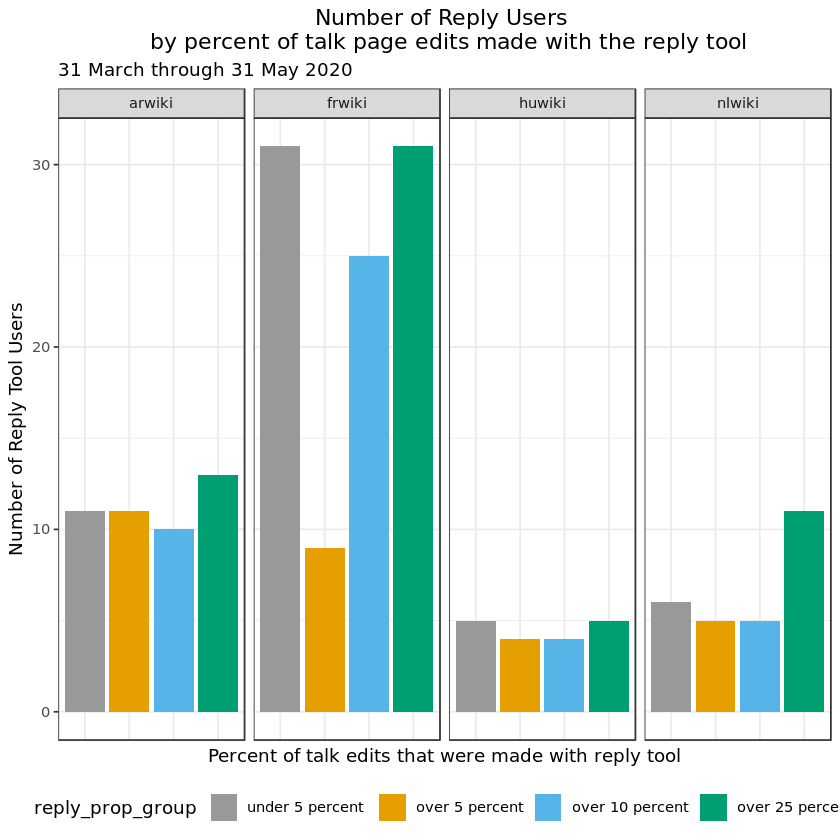

In [397]:
# graph of per wiki numbers

cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442")

p <- prop_reply_edits_clean %>%
    filter(!is.na(reply_prop_group)) %>% # a couple cases where there is a reply edit but not talk edit
    ggplot(aes(x=reply_prop_group, y = n_users, fill = reply_prop_group)) +
    geom_col() +
    facet_grid(~wiki) +
    labs (y = "Number of Reply Tool Users",
          x = "Percent of talk edits that were made with reply tool",
         title = "Number of Reply Users \n by percent of talk page edits made with the reply tool",
         subtitle = "31 March through 31 May 2020")  +
     theme_bw() +
    scale_fill_manual(values=cbPalette) +
   theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.position = "bottom",
        plot.title = element_text(hjust = 0.5)) 
 
        
p

In [398]:
ggsave("Figures/prop_reply_edits_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)